In [5]:
#pip install transformers datasets torch accelerate peft
#pip install kagglehub
#pip install matplotlib
#!pip install ipywidgets
#!pip install fastapi uvicorn gradio torch transformers

In [6]:
# from transformers import AutoModelForCausalLM, AutoTokenizer

# BASE_MODEL = "meta-llama/Llama-3.1-8B-Instruct"  # Official model name
# SAVE_PATH = r"C:\Users\Joshua\Desktop\python_ai\llm_code\llama31\Llama-3.1-8B-Instruct"  # Your directory

# # Download tokenizer and model
# tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
# model = AutoModelForCausalLM.from_pretrained(BASE_MODEL)

# # Save over existing directory
# tokenizer.save_pretrained(SAVE_PATH)
# model.save_pretrained(SAVE_PATH)

# print(f"✅ Model successfully downloaded and saved at: {SAVE_PATH}")


In [4]:
import kagglehub
import pandas as pd
import os, json, random
from textwrap import dedent
from typing import Dict
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import numpy as np
from sklearn.model_selection import train_test_split

from transformers import AutoModelForCausalLM, TrainingArguments, AutoTokenizer, BitsAndBytesConfig, pipeline
from transformers.trainer_utils import get_last_checkpoint

from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel
from trl import SFTConfig
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
import torch
import re


In [4]:
model_id = r"C:\Users\Joshua\Desktop\python_ai\llm_code\llama31\Llama-3.1-8B-Instruct"

# Loading model
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
) # INSPECT MORE

llm_model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_id,
    quantization_config=quantization_config,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

# Tokenizer
# Tokenizer
special_tokens_dict = {
    "bos_token": "<s>",
    "eos_token": "</s>",
    "pad_token": "<pad>",
    "additional_special_tokens": ["<EQ>", "<EXPL>"]
}

tokenizer = AutoTokenizer.from_pretrained(model_id)
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

if num_added_tokens > 0:
    llm_model.resize_token_embeddings(len(tokenizer)) #, pad_to_multiple_of=8

# Debug
print("New tokens added:", num_added_tokens)
print("Tokenizer vocabulary size:", len(tokenizer))
print("Model embedding size:", llm_model.get_input_embeddings().weight.size(0))
print("Special tokens:")
print("  BOS token:", tokenizer.bos_token)
print("  EOS token:", tokenizer.eos_token)
print("  PAD token:", tokenizer.pad_token)
print("  Additional special tokens:", tokenizer.additional_special_tokens)

c:\Users\Joshua\Desktop\python_ai\.venv\Lib\site-packages\accelerate\utils\modeling.py:841: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  _ = torch.tensor([0], device=i)


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


New tokens added: 5
Tokenizer vocabulary size: 128261
Model embedding size: 128261
Special tokens:
  BOS token: <s>
  EOS token: </s>
  PAD token: </s>
  Additional special tokens: ['<EQ>', '<EXPL>']


In [8]:
dataset_path = r"C:\Users\Joshua\Desktop\python_ai\llm_code\datasets\pc_build_parts_cleaned.json"

with open(dataset_path, 'r') as file:
    dataset = json.load(file)


budget_template = "Build me a PC around ${budget}."

def format_parts(parts, float_cost, total):
    result = f"To produce a build under ${float_cost}\n\n"
    for i, part in enumerate(parts, start=1):
        result += f"{i}. **{part['Type']}**: {part['Name']} - {part['Price']}\n"
    result += f"\n**Total Cost:**: ${total}"
    return result

def round_to_nearest_100(value):
    return round(float(value) / 100) * 100

rows = []
for build in dataset:
    description = " ".join(build["Description"])
    parts = build["Part List"]["Parts"]
    total_cost = build["Part List"]["Total"]
    clean_cost = re.sub(r'[^0-9.]', '', total_cost)
    float_cost = float(clean_cost)
    rounded_cost = round_to_nearest_100(float_cost)
    rows.append({
        "question": budget_template.format(budget=rounded_cost),
        "context": f"{description}.",
        "answer": f"{format_parts(parts, float_cost, clean_cost)}"
    })

df = pd.DataFrame(rows)
formatted_output = format_parts(parts, float_cost, clean_cost)
print(formatted_output)

To produce a build under $540.77

1. **CPU**: Intel Core i5-10600KF 4.1 GHz 6-Core Processor - $84.22 USD
2. **Motherboard**: Asus PRIME H410M-E Micro ATX LGA1200 Motherboard - $150.00
3. **Memory**: Corsair Vengeance LPX 16 GB (2 x 8 GB) DDR4-3200 CL16 Memory - $21.82 USD
4. **Storage**: Toshiba DT01ACA200 2 TB 3.5" 7200 RPM Internal Hard Drive - $90.00
5. **Storage**: Western Digital SN530 512 GB M.2-2280 PCIe 3.0 X4 NVME Solid State Drive - $21.82 USD
6. **Video Card**: Asus Phoenix OC GeForce GTX 1660 SUPER 6 GB Video Card - $72.73 USD
7. **Case**: KOLINK OBSERVATORY LITE MESH RGB ATX Mid Tower Case - $21.82 USD
8. **Custom**: ZALMAN's CNPS9X Optima w/White LED Fan - $13.96 USD
9. **Custom**: LogiLink PC0057 PCI Expres Card 4x USB3.0 - $14.40 USD
10. **Custom**: Energon EP​​S-750W IT​E​M NO.: 8​88​82021 - $50.00

**Total Cost:**: $540.77


In [9]:
df.isnull().value_counts()
df

,question,context,answer
0,Build me a PC around $1400.,My Sons 1st Build.. used for school and some g...,To produce a build under $1434.46\n\n1. **CPU*...
1,Build me a PC around $2700.,My first gaming pc in 8 years and first ever s...,To produce a build under $2730.0\n\n1. **CPU**...
2,Build me a PC around $4300.,Built the quietest gaming PC with an AMD Ryzen...,To produce a build under $4260.52\n\n1. **CPU*...
3,Build me a PC around $1000.,This is the product of some parts swaps for a ...,To produce a build under $981.96\n\n1. **CPU**...
4,Build me a PC around $5400.,Decided to upgrade form the 13900k to 14900kf....,To produce a build under $5439.51\n\n1. **CPU*...
...,...,...,...
6029,Build me a PC around $7200.,Gaming..,To produce a build under $7174.34\n\n1. **CPU*...
6030,Build me a PC around $3800.,"cat videos at 8k WHO Aside from cat videos, th...",To produce a build under $3804.62\n\n1. **CPU*...
6031,Build me a PC around $700.,After 4 years with the Ryzen 5 2600 and RX 570...,To produce a build under $727.74\n\n1. **CPU**...
6032,Build me a PC around $4200.,Built a PC for my gf and she made it her own. ...,To produce a build under $4222.53\n\n1. **CPU*...


In [10]:
def format_dataset(row: dict):
    prompt = dedent(
        f"""
    {row["question"]}

    Information:

    ```
    {row["context"]}
    ```
    """
    )
    messages = [
        {
            "role":"system",
            "content": "Use only the information to answer the question",
        },
        {"role":"user", "content": prompt},
        {"role":"assistant", "content": row["answer"]},
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False)

In [11]:
df["text"] = df.apply(format_dataset, axis=1)

In [12]:
def count_tokens(row: Dict) -> int:
    return len(
        tokenizer(
            row["text"],
            add_special_tokens=True,
            return_attention_mask=False,
        )["input_ids"]
    )

In [13]:
df["token_count"] = df.apply(count_tokens, axis=1)

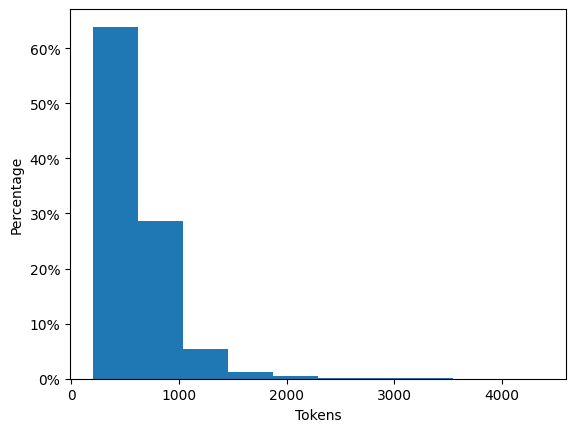

In [14]:
plt.hist(df.token_count, weights=np.ones(len(df.token_count)) / len(df.token_count))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Tokens")
plt.ylabel("Percentage")
plt.show()

In [15]:
# Tell us the length
len(df[df.token_count < 2100]), len(df), len(df[df.token_count < 2100]) / len(df)

(6005, 6034, 0.9951939012263838)

In [16]:
df = df[df.token_count < 2100]
df = df.sample(6000)
df.shape

(6000, 5)

In [17]:
train, temp = train_test_split(df, test_size=0.2)
val, test = train_test_split(temp, test_size=0.2)

len(train), len(val), len(test)

(4800, 960, 240)

In [18]:
print(f"Train dataset size: {len(train)}")
print(f"Validation dataset size: {len(val)}")
print(f"Test dataset size: {len(test)}")

train.sample(n=4000).to_json("split_sets/train.json", orient="records", lines=True)
val.sample(n=500).to_json("split_sets/val.json", orient="records", lines=True)
test.sample(n=200).to_json("split_sets/test.json", orient="records", lines=True)

Train dataset size: 4800
Validation dataset size: 960
Test dataset size: 240


In [19]:
# Finetune Below
print(train.head())

                         question  \
4316  Build me a PC around $3100.   
4234  Build me a PC around $1900.   
4382  Build me a PC around $1100.   
856   Build me a PC around $1500.   
3347  Build me a PC around $1700.   

                                                context  \
4316  First PC I've ever built myself. I'm sure it's...   
4234  Had problems with previous motherboard which w...   
4382  quand j'ai fait ce build j'avais 2×8 GB de RAM...   
856   Gaming computer, obviously. This is an upgrade...   
3347  This is the first build I have completed since...   

                                                 answer  \
4316  To produce a build under $3064.5\n\n1. **CPU**...   
4234  To produce a build under $1915.94\n\n1. **CPU*...   
4382  To produce a build under $1083.7\n\n1. **CPU**...   
856   To produce a build under $1510.0\n\n1. **CPU**...   
3347  To produce a build under $1709.78\n\n1. **CPU*...   

                                                   text  token_coun

In [20]:
dataset = load_dataset(
    "json",
    data_files={"train": "split_sets/train.json", "validation": "split_sets/val.json", "test": "split_sets/test.json"},
)
print(dataset["train"][0]["text"])

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

<s><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

Build me a PC around $1900.

Information:

```
I used it for work, CAD and 3D Modeling..
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>

To produce a build under $1889.48

1. **CPU**: AMD Ryzen 9 5900X 3.7 GHz 12-Core Processor - $549.99 USD
2. **CPU Cooler**: Noctua NH-D15 82.5 CFM CPU Cooler - $99.95 USD
3. **Motherboard**: ASRock X570 Taichi ATX AM4 Motherboard - $249.99 USD
4. **Memory**: Corsair Vengeance LPX 64 GB (2 x 32 GB) DDR4-3600 CL18 Memory - $169.99 USD
5. **Storage**: Intel 660p 2.048 TB M.2-2280 PCIe 3.0 X4 NVME Solid State Drive - $199.99 USD
6. **Storage**: Samsung 980 Pro 1 TB M.2-2280 PCIe 4.0 X4 NVME Solid State Drive - $199.99 USD
7. **Case**: Lian Li O11 Air Mini ATX Mid Tower Case - $119.99 USD
8. **Power Supply**: Corsair RM750 750 W 80+ Gold C

In [21]:
# Pipeline for taking in inputs
# del pipeline
from transformers import pipeline

pipeline = pipeline(
    "text-generation",
    model=llm_model,
    tokenizer=tokenizer,
    return_full_text=False,
    model_kwargs={"torch_dtype": torch.bfloat16},
    #device="cuda",
)

Device set to use cuda:0


In [22]:
def create_test_prompt(data_row):
    prompt = dedent(
        f"""
    {data_row["question"]}

    Information:

    ```
    {data_row["context"]}
    ```
    """
    )
    messages = [
        {
            "role":"system",
            "content": "Use only the provided information to answer the question. Ensure that all parts include their respective prices in the response."
        },
        {"role":"user", "content": prompt},
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

In [23]:
row = dataset["test"][0]
prompt = create_test_prompt(row)
print(prompt)

<s><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

Use only the provided information to answer the question. Ensure that all parts include their respective prices in the response.<|eot_id|><|start_header_id|>user<|end_header_id|>

Build me a PC around $4200.

Information:

```
No RGB! Tower 300: Love this case. Was going to do this build with the Tower 200, but noticed the 300 had released and I am so glad that I did. This case was wonderful to work with. All the panels come off, and make it very easy to build in. Lots of options for routing cables. Looks amazing. Have 8x 140mm fans in this case including those on the AIO. The AIO fans are used as intake to pull air into the case. The GPU has air passthrough so it also pulls in some air while it is running. There is a fan on the PSU cover that blows air up toward the motherboard. 2x fans at the top that exhaust, and 2x fans in the back that also exhaust. So basically air comes 

In [24]:
%%time
outputs = pipeline(
    prompt, 
    max_new_tokens=2000,
    length_penalty=1,
    num_beams=6,
    temperature=0.1,
    top_p=0.8,
    repetition_penalty=1,
    )

responce = f"""
answer:     {row["answer"]}
prediction: {outputs[0]["generated_text"]}
"""
print(responce)

c:\Users\Joshua\Desktop\python_ai\.venv\Lib\site-packages\transformers\integrations\sdpa_attention.py:48: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(



answer:     To produce a build under $4241.94

1. **CPU**: AMD Ryzen 7 7800X3D 4.2 GHz 8-Core Processor - $779.00
2. **CPU Cooler**: ARCTIC Liquid Freezer III 420 72.8 CFM Liquid CPU Cooler - $199.00
3. **Motherboard**: ASRock B650E PG-ITX WIFI Mini ITX AM5 Motherboard - $718.33
4. **Memory**: G.Skill Ripjaws S5 32 GB (2 x 16 GB) DDR5-6400 CL32 Memory - $195.45
5. **Storage**: Sabrent Rocket 5 1 TB M.2-2280 PCIe 5.0 X4 NVME Solid State Drive - $319.99
6. **Video Card**: PNY XLR8 Gaming VERTO EPIC-X RGB OC GeForce RTX 4070 Ti SUPER 16 GB Video Card - $1299.00
7. **Case**: Thermaltake The Tower 300 MicroATX Mini Tower Case - $221.17
8. **Power Supply**: be quiet! Dark Power 13 850 W 80+ Titanium Certified Fully Modular ATX Power Supply - $399.00
9. **Case Fan**: be quiet! Silent Wings 4 51.3 CFM 140 mm Fan - $32.00
10. **Case Fan**: be quiet! Silent Wings 4 51.3 CFM 140 mm Fan - $32.00
11. **Case Fan**: be quiet! Silent Wings 4 51.3 CFM 140 mm Fan - $32.00
12. **Fan Controller**: ARCTIC

In [25]:
collator = DataCollatorForCompletionOnlyLM(response_template="<|end_header_id|>", tokenizer=tokenizer)

examples = [dataset["train"][0]["text"]]
endcodings = [tokenizer(e) for e in examples]

dataloader = DataLoader(endcodings, collate_fn=collator, batch_size=1)

In [26]:
batch = next(iter(dataloader))
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [27]:
batch["labels"]

tensor([[  -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,    271,   1271,
           8356,    264,   1977,   1234,    400,   9367,     24,     13,   2166,
            271,     16,     13,   3146,  32715,  96618,  25300,  93836,    220,
             24,    220,  20615,     15,     55,    220,     18,     13,     22,
          52405,    220,    717,  67529,  44477,    482,    400,  22782,     13,
           1484,  20121,    

In [28]:
# Chosing layers to apply LoRA to
llm_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128261, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((409

In [29]:
peft_config = LoraConfig(
    task_type = "CAUSAL_LM", 
    r = 32, #64
    lora_alpha = 16, #16
    lora_dropout = 0.05, #0.1
    bias = "none",
    target_modules=[
        "self_attn.q_proj",
        "self_attn.k_proj",
        "self_attn.v_proj",
        "self_attn.o_proj",
        "mlp.gate_proj",
        "mlp.up_proj",
        "mlp.down_proj",
    ],
)

llm_model = prepare_model_for_kbit_training(llm_model)
llm_model = get_peft_model(llm_model, peft_config)
llm_model.print_trainable_parameters()

trainable params: 83,886,080 || all params: 8,114,188,288 || trainable%: 1.0338


In [30]:
OUTPUT_DIR = "experiments"

%load_ext tensorboard
%tensorboard --logdir "experiments/runs"

Reusing TensorBoard on port 6006 (pid 1480), started 5 days, 0:24:04 ago. (Use '!kill 1480' to kill it.)

In [31]:
sft_config = SFTConfig(
    output_dir=OUTPUT_DIR,
    resume_from_checkpoint=None,
    dataset_text_field="text",
    max_seq_length=512,
    num_train_epochs=0.01,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    #dataloader_num_workers=4,
    optim="paged_adamw_8bit", #"paged_adamw_8bit"
    evaluation_strategy="steps",
    eval_steps=2,
    save_steps=2,
    logging_steps=10,
    disable_tqdm=False,
    learning_rate=1e-4,
    fp16=True, #or bf16=True
    save_strategy="steps",
    save_total_limit=2,
    lr_scheduler_type="constant",
    report_to="tensorboard",
    save_safetensors=True,
    dataset_kwargs={
        "add_special_tokens": False,  # We template with special tokens
        "append_concat_token": False, # No need to add additional separator token
    },
    #seed=SEED,
)

#torch.backends.cuda.matmul.allow_tf32 = True
#llm_model.gradient_checkpointing_enable()
#llm_model = torch.compile(llm_model)
#seed=SEED SET THIS UP!!!

trainer = SFTTrainer(
    model=llm_model,
    args=sft_config,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=collator,
)

c:\Users\Joshua\Desktop\python_ai\.venv\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [32]:
# Restart or load from checkpoint
load_check = True

def get_latest_checkpoint(output_dir):
    checkpoints = [d for d in os.listdir(output_dir) if d.startswith("checkpoint-")]
    if not checkpoints:
        return None

    latest_checkpoint = max(checkpoints, key=lambda x: int(re.findall(r'\d+', x)[0]))
    return os.path.join(output_dir, latest_checkpoint)

latest_checkpoint = get_latest_checkpoint(OUTPUT_DIR)

if latest_checkpoint and load_check and os.path.exists(os.path.join(latest_checkpoint, "trainer_state.json")):
    with open(os.path.join(latest_checkpoint, "trainer_state.json"), "r") as f:
        trainer_state = json.load(f)
        print("Trainer State Loaded from Checkpoint:")
        print("Epoch:", trainer_state["epoch"])
        print("Global Step:", trainer_state["global_step"])

    print(f"Resuming from latest checkpoint: {latest_checkpoint}")
    trainer.train(resume_from_checkpoint=latest_checkpoint)
else:
    print("No valid checkpoint found. Training from scratch.")
    trainer.train()

Trainer State Loaded from Checkpoint:
Epoch: 1.0
Global Step: 500
Resuming from latest checkpoint: experiments\checkpoint-500


c:\Users\Joshua\Desktop\python_ai\.venv\Lib\site-packages\transformers\trainer.py:3441: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPT

Step,Training Loss,Validation Loss


In [33]:
NEW_MODEL = r"Llama-3.1-8B-Instruct-PCBuilds"
trainer.save_model(NEW_MODEL)

c:\Users\Joshua\Desktop\python_ai\.venv\Lib\site-packages\peft\utils\save_and_load.py:257: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


In [ ]:

#merged_model.config.vocab_size = len(tokenizer)
#merged_model.model.config.vocab_size = len(tokenizer)
#merged_model.save_pretrained(NEW_MODEL)
#tokenizer.save_pretrained(NEW_MODEL)

c:\Users\Joshua\Desktop\python_ai\.venv\Lib\site-packages\accelerate\utils\modeling.py:841: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  _ = torch.tensor([0], device=i)


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


128261
Model token embedding size BEFORE adapter: 128256


The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Model token embedding size AFTER adapter: 128261


c:\Users\Joshua\Desktop\python_ai\.venv\Lib\site-packages\peft\tuners\lora\bnb.py:336: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, GenerationConfig, pipeline
from peft import PeftModel
import gradio as gr
from fastapi import FastAPI

BASE_MODEL_PATH = r"C:\Users\Joshua\Desktop\python_ai\llm_code\llama31\Llama-3.1-8B-Instruct"
FINETUNED_MODEL_PATH = r"Llama-3.1-8B-Instruct-PCBuilds"
MAX_TOKENS = 2048

# Quantization Configuration
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
)

# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(FINETUNED_MODEL_PATH, use_fast=True)

# Load Base Model
model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_PATH,
    torch_dtype=torch.bfloat16,
    quantization_config=quantization_config,
    device_map="auto"
)

print(f"Tokenizer vocab size: {len(tokenizer)}")
print(f"Model token embedding size BEFORE adapter: {model.get_input_embeddings().weight.shape[0]}")

# Resize Model Token Embeddings to Match Tokenizer
model.resize_token_embeddings(len(tokenizer))

# Load PEFT Adapter & Merge
peft_model = PeftModel.from_pretrained(model, FINETUNED_MODEL_PATH)
merged_model = peft_model.merge_and_unload()
print(f"Model token embedding size AFTER adapter: {merged_model.get_input_embeddings().weight.shape[0]}")

text_generator = pipeline(
    "text-generation",
    model=merged_model,
    tokenizer=tokenizer,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
    max_new_tokens = MAX_TOKENS,
    temperature = 0.5,
    top_p = 0.8,
    num_beams = 6,
    pad_token_id = tokenizer.eos_token_id,
)

# Chatbot window
def chatbot_interaction(user_prompt):
    formatted_prompt = (
        f"<s><|start_header_id|>user<|end_header_id|>\n\n"
        f"{user_prompt}\n\n"
        f"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
    )
    response = text_generator(formatted_prompt)
    model_answer = response[0]['generated_text']

    unwanted_tokens = ["<|start_header_id|>user<|end_header_id|>", "<|eot_id|>", "<|start_header_id|>assistant<|end_header_id|>", "<s>"]
    for token in unwanted_tokens:
        model_answer = model_answer.replace(token, "").strip()
    return model_answer 

app = FastAPI()

@app.get("/")
def read_root():
    return {"message": "Chatbot API is running!"}

@app.post("/chat")
def chat(prompt: str):
    return {"response": chatbot_interaction(prompt)}

gr.Interface(
    fn=chatbot_interaction,
    inputs=gr.Textbox(lines=2, placeholder="Ask something..."),
    outputs="text",
    title="Llama-3.1 PC Build Chatbot",
).launch(server_name="0.0.0.0", server_port=7860, share=True)


c:\Users\Joshua\Desktop\python_ai\.venv\Lib\site-packages\accelerate\utils\modeling.py:841: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  _ = torch.tensor([0], device=i)


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Tokenizer vocab size: 128261
Model token embedding size BEFORE adapter: 128256


The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
c:\Users\Joshua\Desktop\python_ai\.venv\Lib\site-packages\peft\tuners\lora\bnb.py:336: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(
Device set to use cuda:0


Model token embedding size AFTER adapter: 128261
* Running on local URL:  http://0.0.0.0:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


c:\Users\Joshua\Desktop\python_ai\.venv\Lib\site-packages\transformers\integrations\sdpa_attention.py:48: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
